In [41]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Add, Activation, LSTM
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [42]:
# Access Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
# Load datasets
bitcoin_data_path = '/content/drive/MyDrive/dataset/Bitcoin Historical Data.csv'
nasdaq_data_path = '/content/drive/MyDrive/dataset/NASDAQ Composite Historical Data.csv'
usd_data_path = '/content/drive/MyDrive/dataset/US Dollar Index Futures Historical Data.csv'

In [44]:
# Define a function to preprocess each dataset
def preprocess_data(data_path, date_format='%d/%m/%Y'):
  df = pd.read_csv(data_path)
  df = df[::-1] # Reverse the order
  df.fillna(method='ffill', inplace=True)
  df['Price'] = df['Price'].str.replace(',', '').astype(float)
  df['Date'] = pd.to_datetime(df['Date'], format=date_format)
  return df

In [45]:
# Define a function to preprocess each dataset
def preprocess_us_data(data_path, date_format='%m/%d/%Y'):
    df = pd.read_csv(data_path)
    df = df[::-1]  # Reverse the order
    df.fillna(method='ffill', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)
    return df

In [46]:
# Preprocess each dataset
bitcoin_df = preprocess_data(bitcoin_data_path)
nasdaq_df = preprocess_data(nasdaq_data_path)
usd_df = preprocess_us_data(usd_data_path)

# DATASET BITCOIN

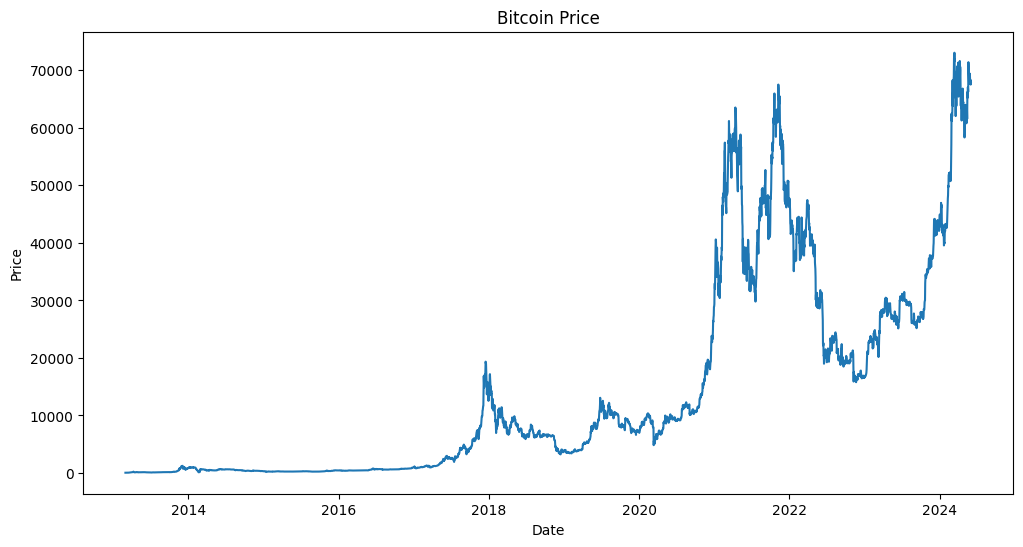

In [47]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_df['Date'], bitcoin_df['Price'])
plt.title('Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# DATASET NASDAQ


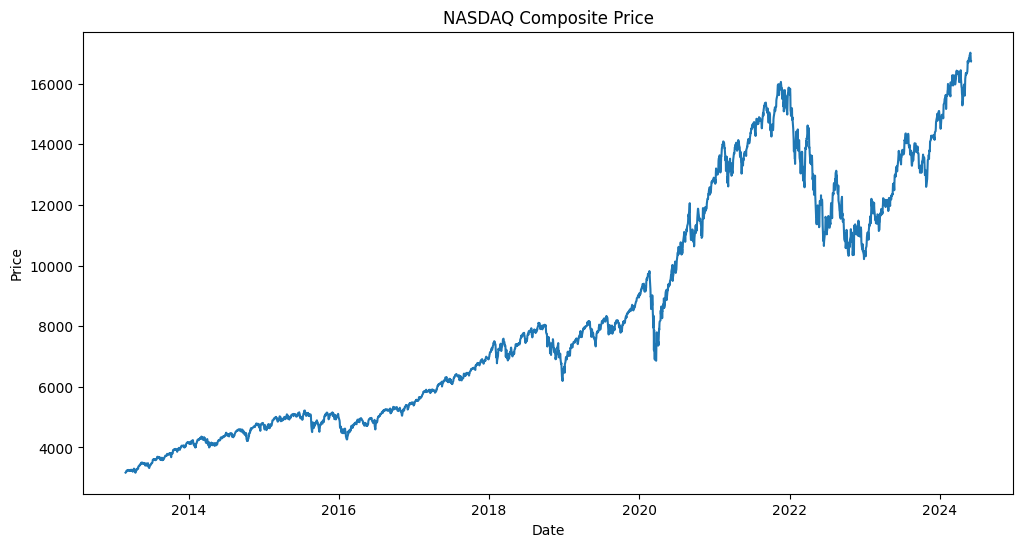

In [48]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(nasdaq_df['Date'], nasdaq_df['Price'])
plt.title('NASDAQ Composite Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# DATASET US Dollar Index

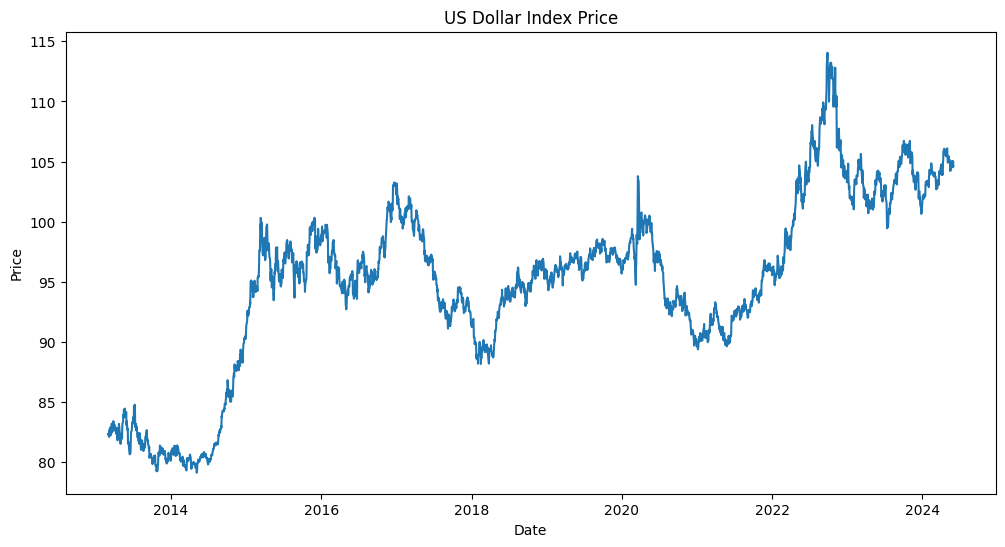

In [49]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(usd_df['Date'], usd_df['Price'])
plt.title('US Dollar Index Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [50]:
# Define a function to create sequences and perform forecasting
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length][0]  # Predicting 'Price'
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [51]:
def rolling_forecast_future(model, data, steps, scaler, window_size=30):
    forecast = []
    last_sequence = data[-window_size:]

    for _ in range(steps // window_size):
        predictions = []

        for _ in range(window_size):
            prediction = model.predict(last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1]))
            predictions.append(prediction[0][0])
            last_sequence = np.roll(last_sequence, -1, axis=0)
            last_sequence[-1, 0] = prediction[0][0]

        forecast.extend(predictions)

    forecast = np.array(forecast)
    forecast_with_features = np.zeros((forecast.shape[0], data.shape[1]))
    forecast_with_features[:, 0] = forecast  # Fill in the 'Price' predictions

    forecast_with_features = scaler.inverse_transform(forecast_with_features)
    forecast_prices = forecast_with_features[:, 0]  # Extract the 'Price' column

    return forecast_prices

In [52]:
# Function to split data into training and testing sets
def split_data(X, y, ratio):
    train_size = int(len(X) * ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

In [53]:
def build_res_cnn_block(input_layer):
    conv1 = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu')(input_layer)
    conv1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu')(conv1)
    conv2 = Conv1D(filters=64, kernel_size=2, padding='same', activation='linear')(conv2)
    skip_connection = Add()([conv1, conv2])
    skip_connection = Activation('relu')(skip_connection)
    return skip_connection

In [54]:
def build_rescnn_lstm_model(input_shape):
    input_layer = Input(shape=input_shape)
    res_cnn_block1 = build_res_cnn_block(input_layer)
    res_cnn_block2 = build_res_cnn_block(res_cnn_block1)
    lstm_layer = LSTM(64, return_sequences=False)(res_cnn_block2)
    dense1 = Dense(32, activation='relu')(lstm_layer)
    output_layer = Dense(1, activation='linear')(dense1)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

In [55]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=1):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test))
    predicted_prices = model.predict(X_test).flatten()
    mae = mean_absolute_error(y_test, predicted_prices)
    rmse = np.sqrt(mean_squared_error(y_test, predicted_prices))
    mape = np.mean(np.abs((y_test - predicted_prices) / y_test)) * 100
    return predicted_prices, mae, rmse, mape

In [56]:
def process_dataset(df, dataset_name, split_ratio):
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Price']])

    # Create sequences
    sequence_length = 30
    X, y = create_sequences(scaled_data, sequence_length)

    # Split data
    X_train, X_test, y_train, y_test = split_data(X, y, split_ratio)

    # Build and train model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_rescnn_lstm_model(input_shape)
    predicted_prices, mae, rmse, mape = train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=100)

    # Inverse transform to get actual prices
    y_test_reshaped = y_test.reshape(-1, 1)
    predicted_prices_reshaped = predicted_prices.reshape(-1, 1)
    actual_prices = scaler.inverse_transform(np.hstack((y_test_reshaped, np.zeros((y_test_reshaped.shape[0], scaled_data.shape[1]-1)))))[:, 0]
    predicted_prices_actual = scaler.inverse_transform(np.hstack((predicted_prices_reshaped, np.zeros((predicted_prices_reshaped.shape[0], scaled_data.shape[1]-1)))))[:, 0]

    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df['Price'], color='blue', label='Training Data', linestyle='solid')
    plt.plot(df['Date'][len(df) - len(y_test):], actual_prices, color='orange', label='Actual Price', linestyle='solid')
    plt.plot(df['Date'][len(df) - len(y_test):], predicted_prices_actual, color='green', label='Predicted Price', linestyle='solid')

    # Rolling forecast future prices
    forecast_30 = rolling_forecast_future(model, scaled_data, 30, scaler)
    forecast_60 = rolling_forecast_future(model, scaled_data, 60, scaler)
    forecast_90 = rolling_forecast_future(model, scaled_data, 90, scaler)

    forecast_dates_30 = pd.date_range(start=df['Date'].iloc[-1], periods=30, freq='D')
    forecast_dates_60 = pd.date_range(start=df['Date'].iloc[-1], periods=60, freq='D')
    forecast_dates_90 = pd.date_range(start=df['Date'].iloc[-1], periods=90, freq='D')

    plt.plot(forecast_dates_30, forecast_30, color='brown', label='Next 30 Days Forecast', linestyle='solid')
    plt.plot(forecast_dates_60[30:], forecast_60[30:], color='yellow', label='Next 60 Days Forecast', linestyle='solid')
    plt.plot(forecast_dates_90[60:], forecast_90[60:], color='red', label='Next 90 Days Forecast', linestyle='solid')

    plt.title(f'ResCNN {dataset_name} Time Series Forecast Ratio {round(split_ratio * 10)}:{round((1 - split_ratio) * 10)}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {'mae': mae, 'rmse': rmse, 'mape': mape}

# BITCOIN

# RATIO 6:4


Epoch 1/100
77/77 [==============================] - 8s 34ms/step - loss: 1.6657e-04 - val_loss: 0.0079
Epoch 2/100
77/77 [==============================] - 2s 21ms/step - loss: 5.2498e-05 - val_loss: 0.0090
Epoch 3/100
77/77 [==============================] - 2s 21ms/step - loss: 3.9796e-05 - val_loss: 0.0089
Epoch 4/100
77/77 [==============================] - 2s 21ms/step - loss: 3.8777e-05 - val_loss: 0.0121
Epoch 5/100
77/77 [==============================] - 2s 31ms/step - loss: 3.4707e-05 - val_loss: 0.0085
Epoch 6/100
77/77 [==============================] - 3s 36ms/step - loss: 2.6213e-05 - val_loss: 0.0089
Epoch 7/100
77/77 [==============================] - 2s 24ms/step - loss: 2.4718e-05 - val_loss: 0.0074
Epoch 8/100
77/77 [==============================] - 2s 20ms/step - loss: 3.4177e-05 - val_loss: 0.0077
Epoch 9/100
77/77 [==============================] - 2s 20ms/step - loss: 2.5907e-05 - val_loss: 0.0059
Epoch 10/100
77/77 [==============================] - 2s 20ms/st

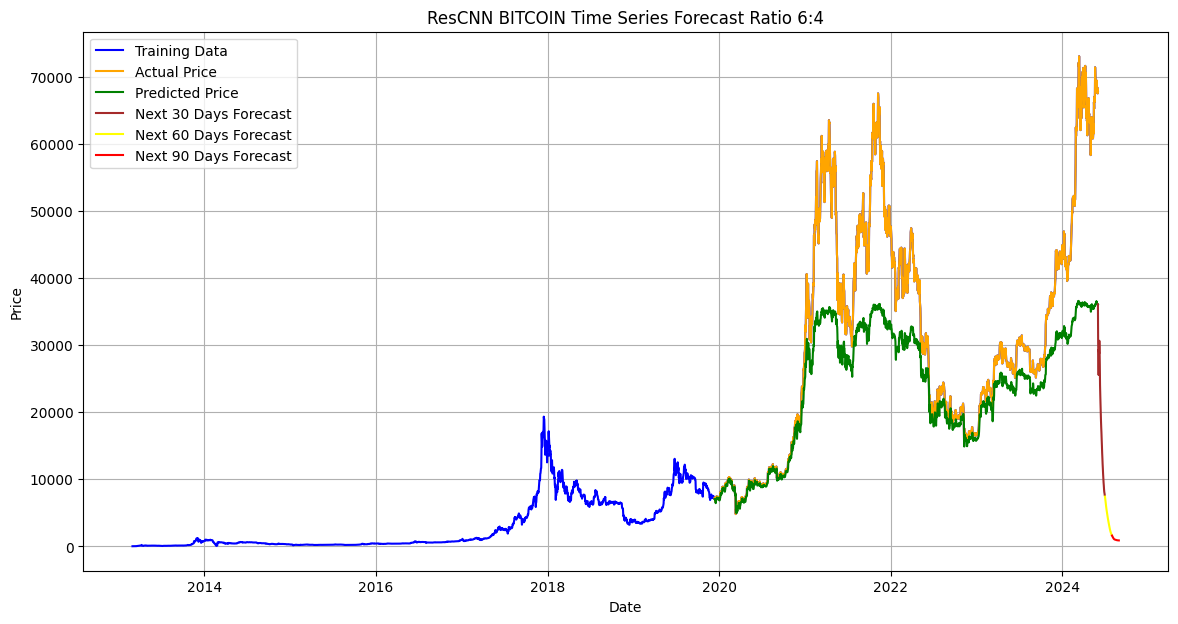

Testing MAE: 0.1066
Testing RMSE: 0.1611
Testing MAPE: 17.62%


In [57]:
results = process_dataset(bitcoin_df, "BITCOIN", 0.6)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 7:3

Epoch 1/100
90/90 [==============================] - 7s 26ms/step - loss: 4.4167e-04 - val_loss: 0.0016
Epoch 2/100
90/90 [==============================] - 2s 20ms/step - loss: 1.1924e-04 - val_loss: 9.8246e-04
Epoch 3/100
90/90 [==============================] - 2s 20ms/step - loss: 1.6966e-04 - val_loss: 0.0025
Epoch 4/100
90/90 [==============================] - 2s 20ms/step - loss: 7.0781e-05 - val_loss: 7.4093e-04
Epoch 5/100
90/90 [==============================] - 3s 30ms/step - loss: 6.0932e-05 - val_loss: 6.8620e-04
Epoch 6/100
90/90 [==============================] - 3s 31ms/step - loss: 4.3509e-05 - val_loss: 0.0012
Epoch 7/100
90/90 [==============================] - 2s 24ms/step - loss: 3.5500e-05 - val_loss: 0.0024
Epoch 8/100
90/90 [==============================] - 2s 19ms/step - loss: 3.5165e-05 - val_loss: 0.0073
Epoch 9/100
90/90 [==============================] - 2s 20ms/step - loss: 4.7431e-05 - val_loss: 7.0523e-04
Epoch 10/100
90/90 [============================

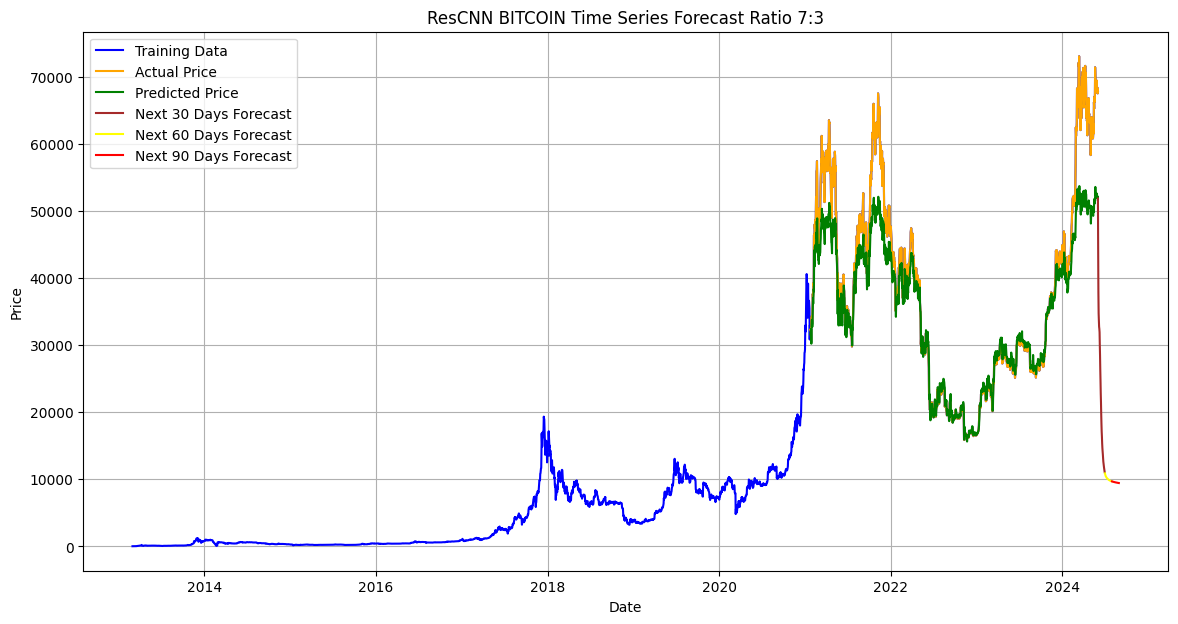

Testing MAE: 0.0462
Testing RMSE: 0.0772
Testing MAPE: 6.67%


In [58]:
results = process_dataset(bitcoin_df, "BITCOIN", 0.7)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 8:2

Epoch 1/100
102/102 [==============================] - 6s 23ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 2/100
102/102 [==============================] - 2s 16ms/step - loss: 3.3705e-04 - val_loss: 8.3317e-04
Epoch 3/100
102/102 [==============================] - 2s 17ms/step - loss: 2.9127e-04 - val_loss: 3.3922e-04
Epoch 4/100
102/102 [==============================] - 2s 18ms/step - loss: 2.2499e-04 - val_loss: 4.8261e-04
Epoch 5/100
102/102 [==============================] - 3s 28ms/step - loss: 2.4188e-04 - val_loss: 3.5043e-04
Epoch 6/100
102/102 [==============================] - 3s 28ms/step - loss: 2.1037e-04 - val_loss: 4.5753e-04
Epoch 7/100
102/102 [==============================] - 2s 18ms/step - loss: 1.7350e-04 - val_loss: 4.2510e-04
Epoch 8/100
102/102 [==============================] - 2s 16ms/step - loss: 1.9146e-04 - val_loss: 0.0013
Epoch 9/100
102/102 [==============================] - 2s 17ms/step - loss: 1.6443e-04 - val_loss: 3.4862e-04
Epoch 10/100
102/102 [

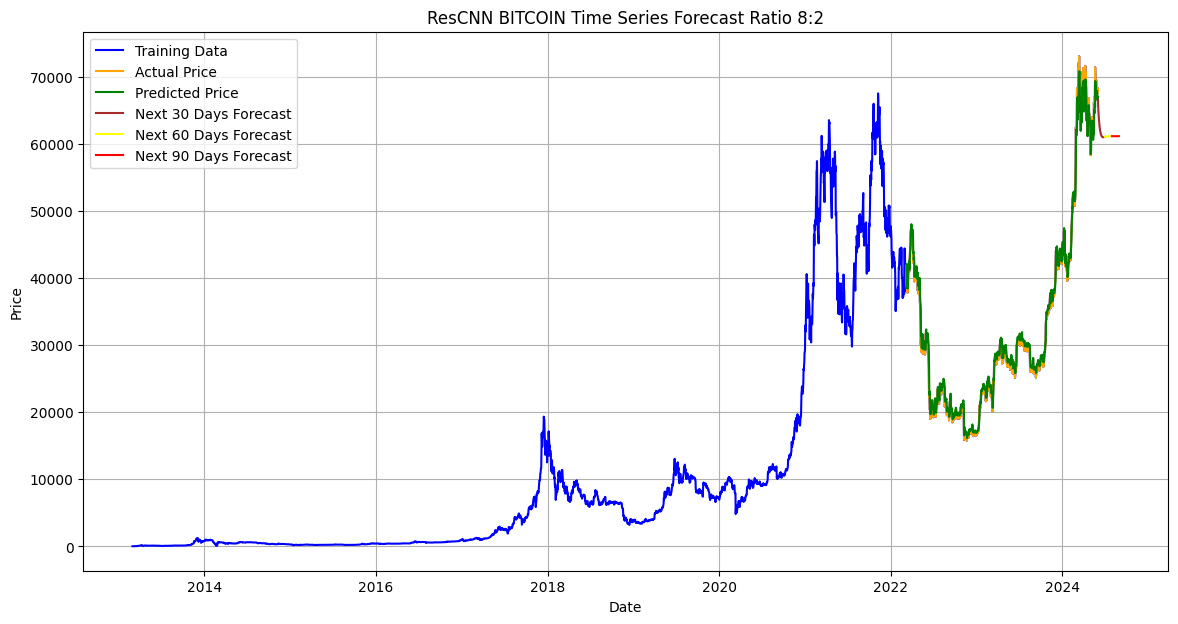

Testing MAE: 0.0117
Testing RMSE: 0.0162
Testing MAPE: 2.69%


In [59]:
results = process_dataset(bitcoin_df, "BITCOIN", 0.8)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# NASDAQ

# RATIO 6:4

Epoch 1/100
53/53 [==============================] - 5s 32ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 2/100
53/53 [==============================] - 1s 22ms/step - loss: 1.0944e-04 - val_loss: 0.0030
Epoch 3/100
53/53 [==============================] - 1s 20ms/step - loss: 9.1054e-05 - val_loss: 0.0024
Epoch 4/100
53/53 [==============================] - 1s 23ms/step - loss: 8.7420e-05 - val_loss: 0.0026
Epoch 5/100
53/53 [==============================] - 2s 34ms/step - loss: 8.5754e-05 - val_loss: 0.0015
Epoch 6/100
53/53 [==============================] - 2s 33ms/step - loss: 7.1569e-05 - val_loss: 0.0018
Epoch 7/100
53/53 [==============================] - 2s 35ms/step - loss: 7.1715e-05 - val_loss: 0.0016
Epoch 8/100
53/53 [==============================] - 1s 23ms/step - loss: 7.8079e-05 - val_loss: 0.0021
Epoch 9/100
53/53 [==============================] - 1s 20ms/step - loss: 7.1443e-05 - val_loss: 0.0025
Epoch 10/100
53/53 [==============================] - 1s 20ms/step -

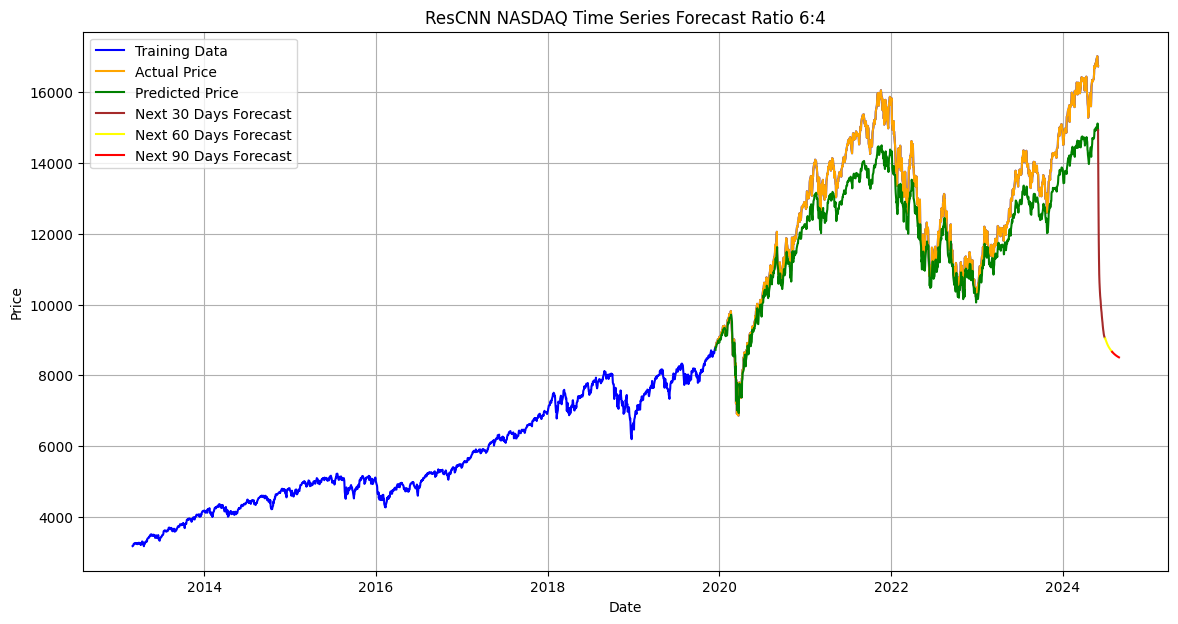

Testing MAE: 0.0514
Testing RMSE: 0.0615
Testing MAPE: 6.81%


In [60]:
results = process_dataset(nasdaq_df, "NASDAQ", 0.6)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 7:3

Epoch 1/100
62/62 [==============================] - 6s 29ms/step - loss: 0.0036 - val_loss: 9.8191e-04
Epoch 2/100
62/62 [==============================] - 1s 21ms/step - loss: 2.0909e-04 - val_loss: 0.0010
Epoch 3/100
62/62 [==============================] - 1s 19ms/step - loss: 1.9490e-04 - val_loss: 8.0763e-04
Epoch 4/100
62/62 [==============================] - 1s 18ms/step - loss: 1.8343e-04 - val_loss: 9.3505e-04
Epoch 5/100
62/62 [==============================] - 1s 21ms/step - loss: 1.7402e-04 - val_loss: 6.4978e-04
Epoch 6/100
62/62 [==============================] - 2s 30ms/step - loss: 1.5757e-04 - val_loss: 0.0011
Epoch 7/100
62/62 [==============================] - 2s 32ms/step - loss: 1.3267e-04 - val_loss: 5.9108e-04
Epoch 8/100
62/62 [==============================] - 2s 29ms/step - loss: 1.3555e-04 - val_loss: 6.4256e-04
Epoch 9/100
62/62 [==============================] - 1s 18ms/step - loss: 1.1072e-04 - val_loss: 4.8598e-04
Epoch 10/100
62/62 [====================

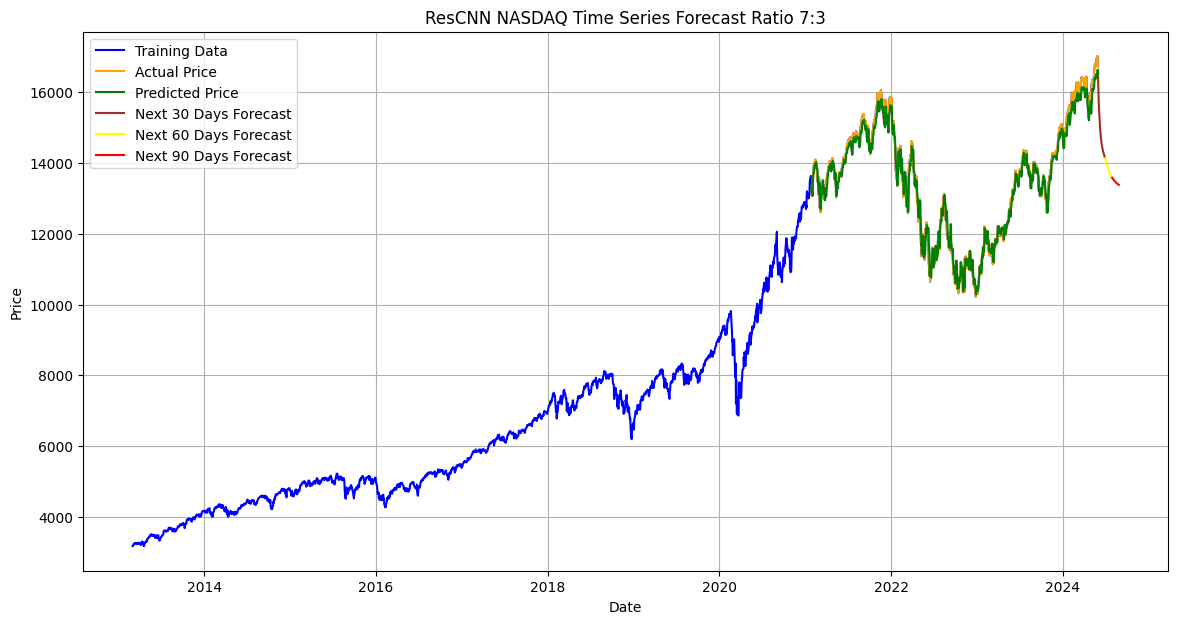

Testing MAE: 0.0127
Testing RMSE: 0.0157
Testing MAPE: 1.71%


In [61]:
results = process_dataset(nasdaq_df, "NASDAQ", 0.7)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 8:2

Epoch 1/100
71/71 [==============================] - 7s 28ms/step - loss: 0.0063 - val_loss: 0.0015
Epoch 2/100
71/71 [==============================] - 1s 18ms/step - loss: 3.3481e-04 - val_loss: 0.0011
Epoch 3/100
71/71 [==============================] - 1s 19ms/step - loss: 3.1068e-04 - val_loss: 0.0010
Epoch 4/100
71/71 [==============================] - 1s 18ms/step - loss: 2.5037e-04 - val_loss: 8.0562e-04
Epoch 5/100
71/71 [==============================] - 1s 18ms/step - loss: 4.0828e-04 - val_loss: 0.0015
Epoch 6/100
71/71 [==============================] - 1s 18ms/step - loss: 2.9469e-04 - val_loss: 0.0013
Epoch 7/100
71/71 [==============================] - 2s 23ms/step - loss: 3.3801e-04 - val_loss: 8.9213e-04
Epoch 8/100
71/71 [==============================] - 2s 29ms/step - loss: 1.8688e-04 - val_loss: 9.7583e-04
Epoch 9/100
71/71 [==============================] - 2s 31ms/step - loss: 1.6579e-04 - val_loss: 6.3215e-04
Epoch 10/100
71/71 [==============================] 

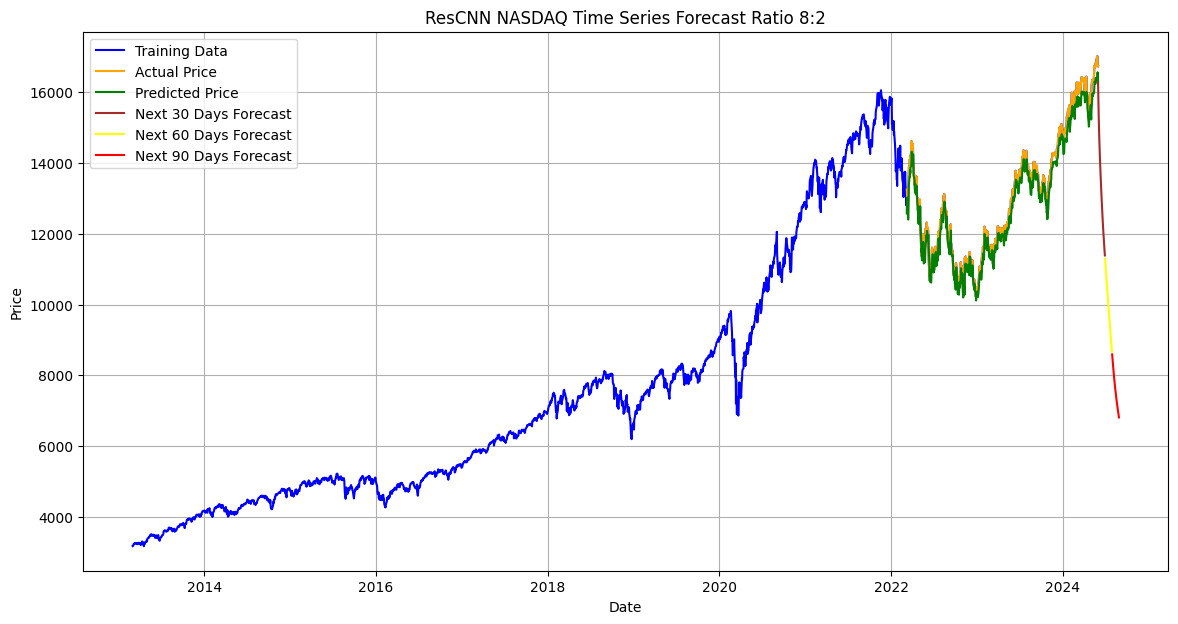

Testing MAE: 0.0184
Testing RMSE: 0.0219
Testing MAPE: 2.53%


In [62]:
results = process_dataset(nasdaq_df, "NASDAQ", 0.8)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# US Dollar

# RATIO 6:4

Epoch 1/100
54/54 [==============================] - 6s 34ms/step - loss: 0.0128 - val_loss: 0.0015
Epoch 2/100
54/54 [==============================] - 1s 23ms/step - loss: 6.7788e-04 - val_loss: 0.0012
Epoch 3/100
54/54 [==============================] - 1s 28ms/step - loss: 6.5714e-04 - val_loss: 9.5101e-04
Epoch 4/100
54/54 [==============================] - 2s 33ms/step - loss: 5.9846e-04 - val_loss: 8.1849e-04
Epoch 5/100
54/54 [==============================] - 2s 41ms/step - loss: 5.0362e-04 - val_loss: 6.4913e-04
Epoch 6/100
54/54 [==============================] - 1s 24ms/step - loss: 4.0754e-04 - val_loss: 4.9503e-04
Epoch 7/100
54/54 [==============================] - 1s 21ms/step - loss: 3.8368e-04 - val_loss: 8.3561e-04
Epoch 8/100
54/54 [==============================] - 1s 21ms/step - loss: 2.7063e-04 - val_loss: 3.2091e-04
Epoch 9/100
54/54 [==============================] - 1s 23ms/step - loss: 3.0772e-04 - val_loss: 8.8761e-04
Epoch 10/100
54/54 [====================

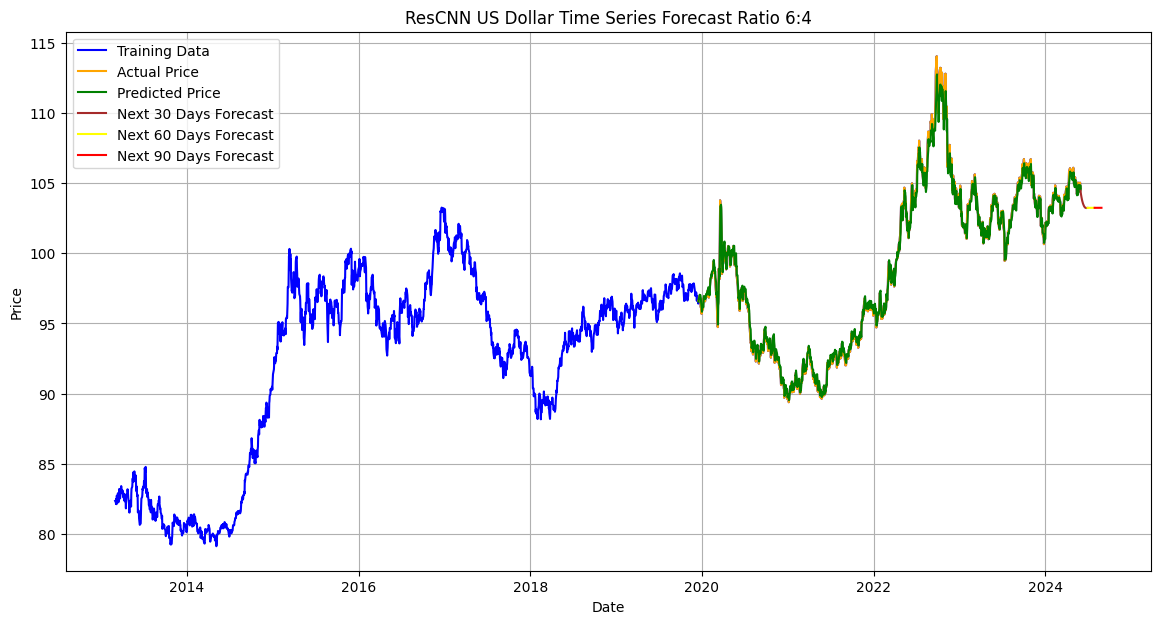

Testing MAE: 0.0107
Testing RMSE: 0.0147
Testing MAPE: 1.87%


In [63]:
results = process_dataset(usd_df, "US Dollar", 0.6)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 7:3

Epoch 1/100
63/63 [==============================] - 6s 29ms/step - loss: 0.0219 - val_loss: 0.0026
Epoch 2/100
63/63 [==============================] - 1s 18ms/step - loss: 7.4987e-04 - val_loss: 0.0022
Epoch 3/100
63/63 [==============================] - 1s 18ms/step - loss: 6.2427e-04 - val_loss: 0.0017
Epoch 4/100
63/63 [==============================] - 1s 21ms/step - loss: 5.4329e-04 - val_loss: 8.1370e-04
Epoch 5/100
63/63 [==============================] - 1s 21ms/step - loss: 4.6752e-04 - val_loss: 6.4045e-04
Epoch 6/100
63/63 [==============================] - 2s 31ms/step - loss: 4.2495e-04 - val_loss: 7.1715e-04
Epoch 7/100
63/63 [==============================] - 2s 34ms/step - loss: 3.0577e-04 - val_loss: 4.2778e-04
Epoch 8/100
63/63 [==============================] - 2s 26ms/step - loss: 2.6215e-04 - val_loss: 2.8625e-04
Epoch 9/100
63/63 [==============================] - 1s 18ms/step - loss: 1.9626e-04 - val_loss: 4.9308e-04
Epoch 10/100
63/63 [========================

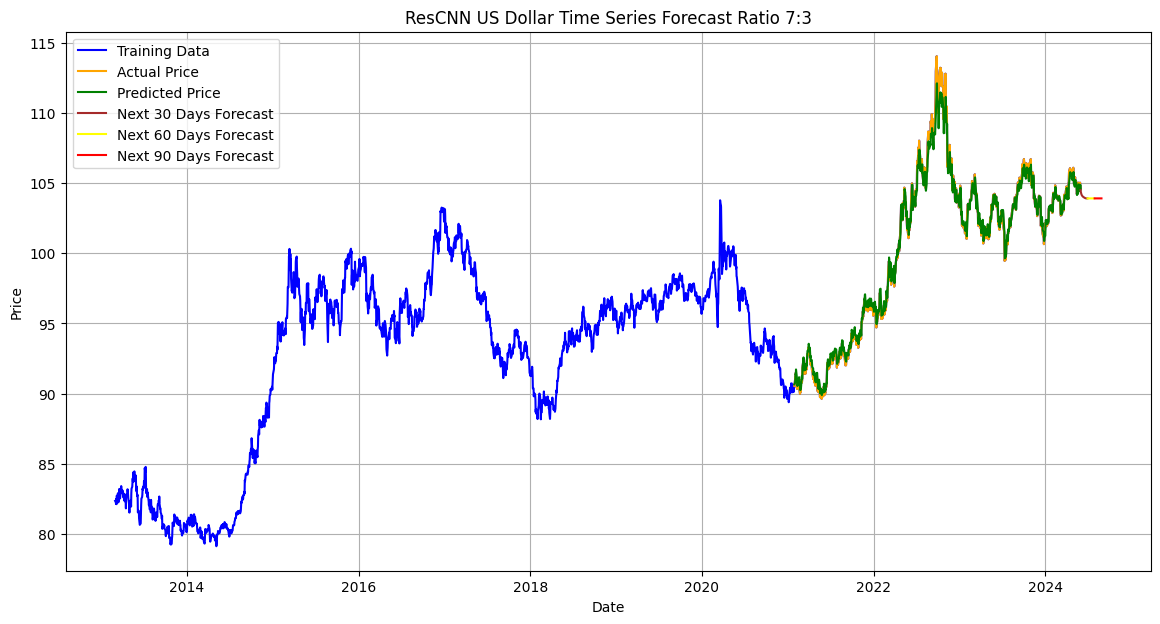

Testing MAE: 0.0119
Testing RMSE: 0.0166
Testing MAPE: 1.95%


In [64]:
results = process_dataset(usd_df, "US Dollar", 0.7)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 8:2

Epoch 1/100
72/72 [==============================] - 7s 40ms/step - loss: 0.0086 - val_loss: 0.0023
Epoch 2/100
72/72 [==============================] - 2s 29ms/step - loss: 6.0985e-04 - val_loss: 0.0015
Epoch 3/100
72/72 [==============================] - 2s 27ms/step - loss: 5.2974e-04 - val_loss: 0.0014
Epoch 4/100
72/72 [==============================] - 1s 18ms/step - loss: 4.2555e-04 - val_loss: 0.0011
Epoch 5/100
72/72 [==============================] - 1s 17ms/step - loss: 3.9293e-04 - val_loss: 5.4665e-04
Epoch 6/100
72/72 [==============================] - 1s 18ms/step - loss: 2.5750e-04 - val_loss: 5.0926e-04
Epoch 7/100
72/72 [==============================] - 1s 18ms/step - loss: 2.4440e-04 - val_loss: 6.3857e-04
Epoch 8/100
72/72 [==============================] - 1s 18ms/step - loss: 2.2275e-04 - val_loss: 2.8912e-04
Epoch 9/100
72/72 [==============================] - 1s 18ms/step - loss: 1.7808e-04 - val_loss: 3.5553e-04
Epoch 10/100
72/72 [============================

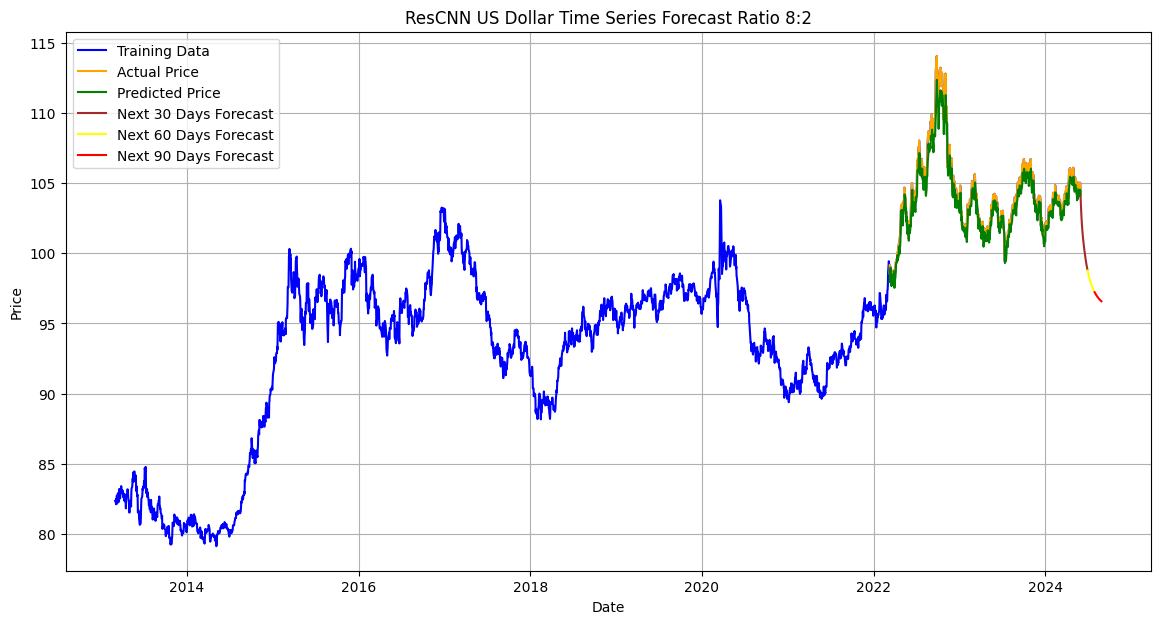

Testing MAE: 0.0172
Testing RMSE: 0.0219
Testing MAPE: 2.31%


In [65]:
results = process_dataset(usd_df, "US Dollar", 0.8)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')